In [12]:
# Bibliotecas
import eda
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from joblib import Parallel, delayed
from itertools import product
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings("ignore")

### Verificando e tratando os dados

In [27]:
dados_manaus = pd.read_csv('Datasets processados/dados_diarios_estacao_14990000.csv', sep=';')
# dados_manaus = pd.read_csv('teste.csv', sep=';')
dados_manaus.drop_duplicates(inplace=True)
dados_manaus.drop_duplicates(subset=['DataCompleta'], inplace=True)
dados_manaus.reset_index(inplace=True, drop=True)
dados_manaus['DataCompleta'] = pd.to_datetime(dados_manaus['DataCompleta'])
dados_manaus.index = dados_manaus['DataCompleta']
dados_manaus.drop(columns=['DataCompleta'], inplace=True)
dados_manaus

,Cota
DataCompleta,
1903-01-01,1914.0
1903-01-02,1921.0
1903-01-03,1924.0
1903-01-04,1926.0
1903-01-05,1929.0
...,...
2025-06-21,2890.0
2025-06-22,2891.0
2025-06-23,2893.0


In [28]:
dados_manaus = dados_manaus.loc['1903-01-01':'2024-12-31']
dados_manaus

,Cota
DataCompleta,
1903-01-01,1914.0
1903-01-02,1921.0
1903-01-03,1924.0
1903-01-04,1926.0
1903-01-05,1929.0
...,...
2024-12-27,1751.0
2024-12-28,1769.0
2024-12-29,1785.0


### Visualizando os dados

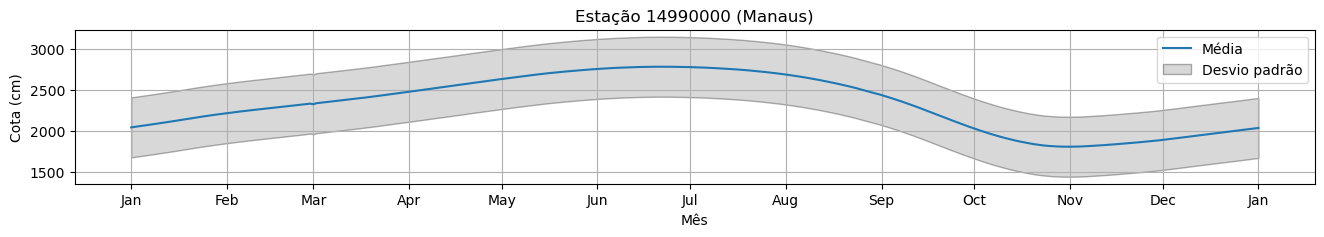

In [4]:
# Variação sazonal
mean = dados_manaus['Cota'].groupby(dados_manaus.index.strftime('%m%d')).mean()
std = np.std(dados_manaus['Cota'])

plt.figure(figsize=(16, 2))
plt.plot(mean)

plt.fill_between(mean.index, mean - std, mean + std, alpha=0.3, edgecolor='black', facecolor='gray')

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.grid(True)
plt.legend(['Média', 'Desvio padrão'])
plt.xlabel('Mês')
plt.ylabel('Cota (cm)')
plt.title('Estação 14990000 (Manaus)')
plt.show()

In [11]:
def max_min_year(series):
  max_year = []
  min_year = []
  first_year =  series.index[0].year
  last_year = series.index[-1].year

  for i in range(first_year,last_year+1):
    aux = series[str(i)+'-01-01':str(i)+'-12-31']
    max_year.append(aux['Cota'].idxmax())
    min_year.append(aux['Cota'].idxmin())

  return max_year,min_year

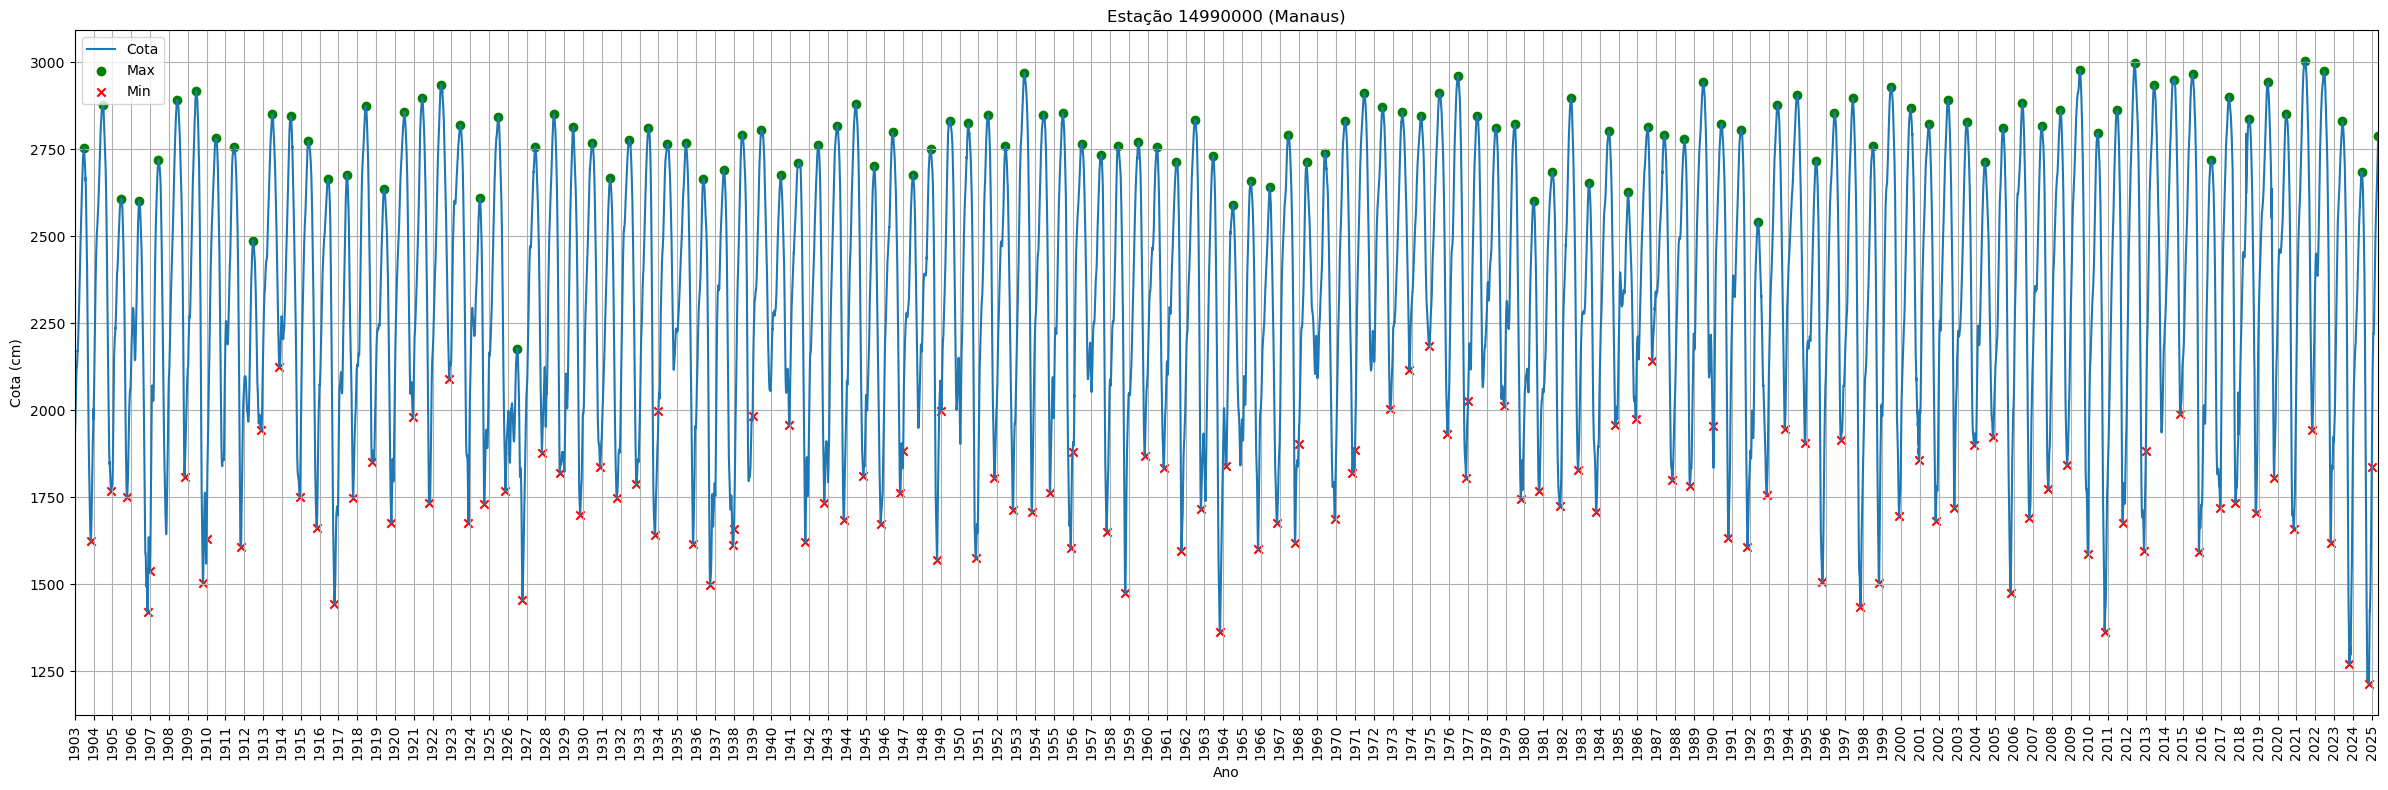

In [12]:
max_year, min_year = max_min_year(dados_manaus)

plt.figure(figsize=(24, 8))
plt.plot(dados_manaus['Cota'])
plt.gca().scatter(max_year, dados_manaus.loc[max_year], marker='o', color='green')
plt.gca().scatter(min_year, dados_manaus.loc[min_year], marker='x', color='red')
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.legend(['Cota', 'Max', 'Min', ])
plt.grid(True)
plt.ylabel('Cota (cm)')
plt.xlabel('Ano')
plt.xlim(dados_manaus.index[0], dados_manaus.index[-1])
plt.title('Estação 14990000 (Manaus)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

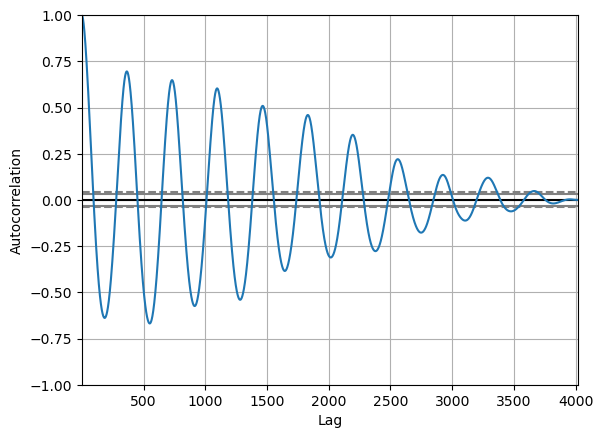

In [35]:
pd.plotting.autocorrelation_plot(dados_manaus['Cota']['1903-01-01':'1913-12-31']).plot()
plt.show()

### Treinamento ML

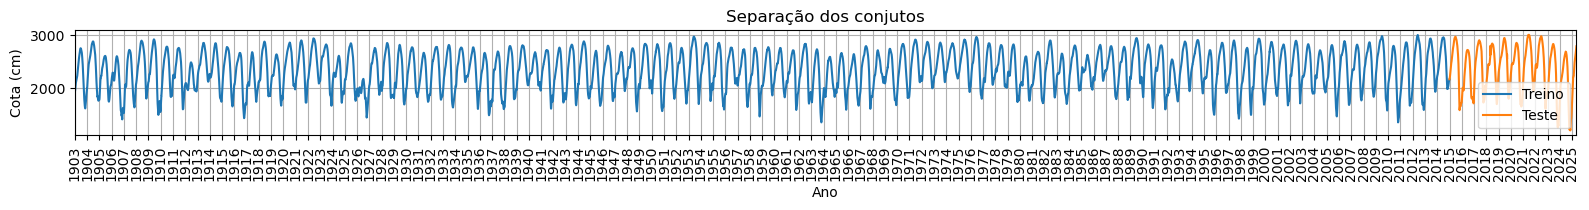

In [8]:
# Separação do conjunto
treino = dados_manaus[:'2014-12-31']
teste = dados_manaus['2015-01-01':]

plt.figure(figsize=(16, 2))
plt.plot(treino['Cota'])
plt.plot(teste['Cota'])
plt.legend(['Treino', 'Teste'])
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlabel('Ano')
plt.ylabel('Cota (cm)')
plt.xticks(rotation=90)
plt.xlim(dados_manaus.index[0], dados_manaus.index[-1])
plt.tight_layout()
plt.title('Separação dos conjutos')
plt.show()

In [36]:
# # Criação de batches
window_length = 365
shifts = np.arange(1,window_length+1)
# Create a dictionary of time-shifted data
x_shifts = {'lag_{}'.format(ii): treino['Cota'].shift(ii) for ii in shifts}
# Convert the shifts into a dataframe
x_shifts = pd.DataFrame(x_shifts)
x_shifts.fillna(0, inplace=True)

#### MLP

In [37]:
def run_iteration(x_shifts, treino, teste, window_length):
    mlp = MLPRegressor(hidden_layer_sizes=(11, 11), max_iter=1000, early_stopping=True, n_iter_no_change=50)
    mlp.fit(x_shifts.iloc[window_length:], treino['Cota'][window_length:])

    test_predictions = []
    first_eval_batch = treino['Cota'][-window_length:].values
    current_batch = first_eval_batch.reshape((1, window_length))

    for i in range(len(teste)):
        current_pred = mlp.predict(current_batch)[0]
        test_predictions.append(current_pred)
        current_batch = np.append(current_batch[:,1:], [[current_pred]], axis=1)

    y_pred = pd.DataFrame(test_predictions, index=teste['Cota'].index)
    r2 = r2_score(teste['Cota'], y_pred)

    return r2, y_pred

# Executa em paralelo
resultados = Parallel(n_jobs=-1)(
    delayed(run_iteration)(x_shifts, treino, teste, window_length) for _ in range(100)
)

# Seleciona o melhor resultado
best_r2, best_y_pred = max(resultados, key=lambda x: x[0])

In [ ]:
# best_r2 = -float('inf')
# best_y_pred = None

# for i in range(100):
#     mlp = MLPRegressor(
#         hidden_layer_sizes=(11, 11), 
#         max_iter=1000, 
#         early_stopping=True, 
#         n_iter_no_change=50)
    
#     mlp.fit(x_shifts.iloc[window_length:], treino['Cota'][window_length:])

#     test_predictions = []
#     first_eval_batch = treino['Cota'][-window_length:].values
#     current_batch = first_eval_batch.reshape((1, window_length))

#     for j in range(len(teste)):
#         # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
#         current_pred = mlp.predict(current_batch)[0]
#         # store prediction
#         test_predictions.append(current_pred)
#         # update batch to now include prediction and drop first value
#         current_batch = np.append(current_batch[:,1:],[[current_pred]],axis=1)
    
#     y_pred = pd.DataFrame(test_predictions)
#     y_pred.index = teste['Cota'].index

#     r2 = r2_score(teste['Cota'], y_pred)

#     if r2 > best_r2:
#         best_r2 = r2
#         best_y_pred = y_pred

In [38]:
best_r2

0.6169163237307989

R² = 0.6169
MSE = 72578.0960
RMSE = 269.4032
MAE = 194.2557


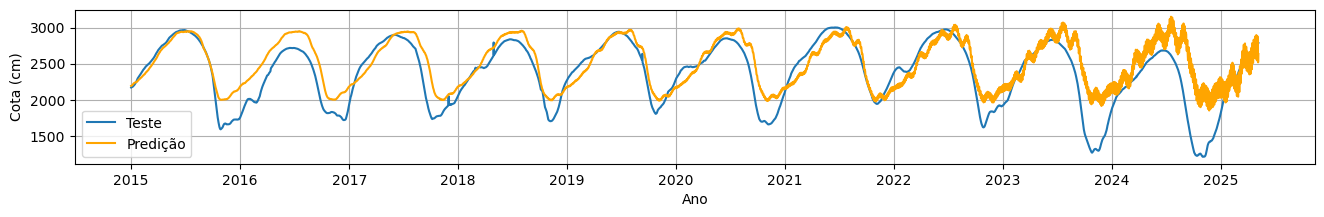

In [39]:
print(f"R² = {r2_score(teste['Cota'], best_y_pred):.4f}")
print(f"MSE = {mean_squared_error(teste['Cota'], best_y_pred):.4f}")
print(f"RMSE = {root_mean_squared_error(teste['Cota'], best_y_pred):.4f}")
print(f"MAE = {mean_absolute_error(teste['Cota'], best_y_pred):.4f}")

plt.figure(figsize=(16, 2))
plt.plot(teste['Cota'], label='Teste')
plt.plot(best_y_pred, label='Predição', color='orange')
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.grid(True)
plt.xlabel('Ano')
plt.ylabel('Cota (cm)')
plt.legend()
plt.show()

#### Random Forest

In [21]:
rf = RandomForestRegressor(n_jobs=-1)

In [22]:
rf.fit(x_shifts.iloc[window_length:], treino['Cota'][window_length:])

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [23]:
test_predictions = []
first_eval_batch = treino['Cota'][-window_length:].values
current_batch = first_eval_batch.reshape((1, window_length))

for i in range(len(teste)):
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = rf.predict(current_batch)[0]
    # store prediction
    test_predictions.append(current_pred)
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:],[[current_pred]],axis=1)

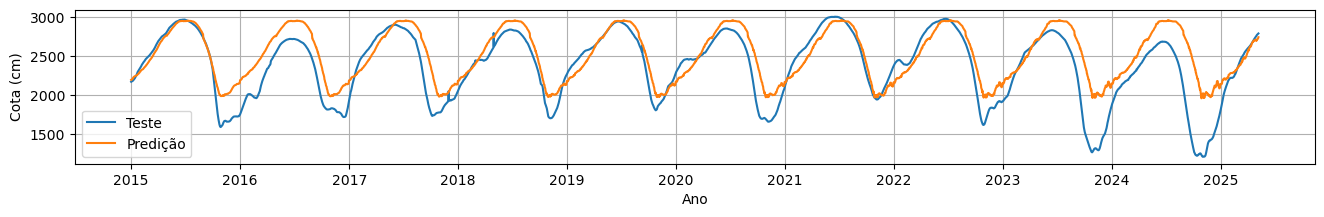

In [24]:
y_pred = pd.DataFrame(test_predictions)
y_pred.index = teste['Cota'].index

plt.figure(figsize=(16, 2))
plt.plot(teste['Cota'], label='Teste')
plt.plot(y_pred, label='Predição')
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.grid(True)
plt.xlabel('Ano')
plt.ylabel('Cota (cm)')
plt.legend()
plt.show()

In [25]:
print(f"R² = {r2_score(teste['Cota'], y_pred):.4f}")
print(f"MSE = {mean_squared_error(teste['Cota'], y_pred):.4f}")
print(f"RMSE = {root_mean_squared_error(teste['Cota'], y_pred):.4f}")
print(f"MAE = {mean_absolute_error(teste['Cota'], y_pred):.4f}")

R² = 0.6167
MSE = 72627.9627
RMSE = 269.4958
MAE = 193.2893


### Outro teste 1

Prever cota da estação jusante usando as cotas das estações montantes

In [29]:
path = 'Datasets processados'
arquivos = [
    'dados_diarios_estacao_14110000.csv',
    # 'dados_diarios_estacao_14300000.csv',
    'dados_diarios_estacao_14420000.csv',
    'dados_diarios_estacao_14480002.csv',
    'dados_diarios_estacao_14840000.csv',
    'dados_diarios_estacao_14990000.csv'
]
dados = eda.data_processing(path, '1985-01-01', '2023-12-31', arquivos)
dados

,14110000,14420000,14480002,14840000,14990000
Data,,,,,
1985-01-01,1766.0,737.0,409.0,669.0,2169.0
1985-01-02,1771.0,760.0,411.0,677.0,2178.0
1985-01-03,1774.0,769.0,413.0,681.0,2186.0
1985-01-04,1773.0,783.0,416.0,685.0,2194.0
1985-01-05,1769.0,788.0,427.0,691.0,2201.0
...,...,...,...,...,...
2023-12-27,1480.0,607.0,325.0,413.0,1807.0
2023-12-28,1485.0,603.0,329.0,421.0,1822.0
2023-12-29,1492.0,601.0,331.0,427.0,1834.0


In [3]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14244 entries, 1985-01-01 to 2023-12-31
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   14110000  14244 non-null  float64
 1   14420000  14244 non-null  float64
 2   14480002  14244 non-null  float64
 3   14840000  14244 non-null  float64
 4   14990000  14244 non-null  float64
dtypes: float64(5)
memory usage: 667.7 KB


In [15]:
dados.to_csv('dados_teste.csv')

In [61]:
dados_dessazonalidados = dados.copy()

for c in dados.columns:
    decompostion = seasonal_decompose(dados[c], model='additive', period=365)
    seasonal = decompostion.seasonal
    deseasonalized_data = dados[c] - seasonal
    dados_dessazonalidados[c] = dados[c] - seasonal

    # plt.figure(figsize=(12, 8))
    # plt.subplot(311)
    # plt.plot(dados[c], label='Original')
    # plt.legend(loc='upper left')
    # plt.subplot(312)
    # plt.plot(seasonal, label='Seasonality')
    # plt.legend(loc='upper left')
    # plt.subplot(313)
    # plt.plot(deseasonalized_data, label='Deseasonalized')
    # plt.legend(loc='upper left')
    # plt.suptitle(c)
    # plt.tight_layout()
    # plt.show()

In [62]:
dados_dessazonalidados

,14110000,14300000,14420000,14480002,14840000,14990000
Data,,,,,,
1985-01-01,1941.113935,896.843654,861.801943,593.158599,1022.390214,2502.949195
1985-01-02,1949.296847,877.785687,881.481611,594.581527,1026.845585,2506.910406
1985-01-03,1954.848109,855.676459,894.581972,596.004526,1027.774424,2509.213579
1985-01-04,1955.030445,819.909480,906.050753,598.638123,1028.203119,2511.122014
1985-01-05,1953.081058,772.490013,911.256233,609.087511,1030.842196,2512.398798
...,...,...,...,...,...,...
2023-12-27,1664.081058,616.490013,730.256233,507.087511,752.842196,2118.398798
2023-12-28,1670.895117,610.833542,725.382765,510.878787,757.165412,2127.043932
2023-12-29,1682.130373,763.285723,723.667336,512.722839,759.725325,2132.978467


In [63]:
tgt = '14990000'

for c in dados_dessazonalidados.columns:
    if c == tgt:
        continue
    best_lag = None
    max_corr = -np.inf

    for i in range(32):
        corr = dados_dessazonalidados[tgt].corr(dados_dessazonalidados[c].shift(i), method='spearman')

        if corr > max_corr:
            max_corr = corr
            best_lag = i
    
    print(f"Estação {c}: Melhor lag = {best_lag}; Correlação = {max_corr:.4f}")

Estação 14110000: Melhor lag = 23; Correlação = 0.4749
Estação 14300000: Melhor lag = 28; Correlação = 0.3330
Estação 14420000: Melhor lag = 19; Correlação = 0.6141
Estação 14480002: Melhor lag = 12; Correlação = 0.7487
Estação 14840000: Melhor lag = 4; Correlação = 0.8749


In [30]:
# X = dados.drop(columns=['14990000'])
# y = pd.DataFrame(dados['14990000'], index=dados.index, columns=['14990000'])

# scaled_x = MinMaxScaler()
# scaled_y = MinMaxScaler()

# x_scaled = scaled_x.fit_transform(X)
# y_scaled = scaled_y.fit_transform(y)

# x_scaled = pd.DataFrame(x_scaled, index=dados.index, columns=X.columns)
# y_scaled = pd.DataFrame(y_scaled, index=dados.index, columns=y.columns)

x_shifts = {
    # '14300000_lag-28': dados['14300000'].shift(28),
    # '14110000_lag-23': dados['14110000'].shift(23),
    # '14420000_lag-19': dados['14420000'].shift(19),
    '14480002_lag-12': dados['14480002'].shift(12),
    '14840000_lag-4': dados['14840000'].shift(4)
}

x_shifts = pd.DataFrame(x_shifts)
x_shifts.fillna(0, inplace=True)
x_shifts

,14480002_lag-12,14840000_lag-4
Data,,
1985-01-01,0.0,0.0
1985-01-02,0.0,0.0
1985-01-03,0.0,0.0
1985-01-04,0.0,0.0
1985-01-05,0.0,669.0
...,...,...
2023-12-27,253.0,374.0
2023-12-28,259.0,388.0
2023-12-29,265.0,396.0


In [31]:
x_train, y_train = x_shifts['1986-01-01':'2014-12-31'], dados['14990000']['1986-01-01':'2014-12-31']
x_test, y_test = x_shifts['2015-01-01':], dados['14990000']['2015-01-01':]

In [18]:
def results(y_test, y_pred):
    print(f"R²: {r2_score(y_test, y_pred):.4f}")
    print(f"MSE: {mean_squared_error(y_test, y_pred):.4f}")
    print(f"RMSE: {root_mean_squared_error(y_test, y_pred):.4f}")
    print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")

    plt.figure(figsize=(16, 2))
    plt.plot(y_test, label='Teste')
    plt.plot(y_pred, label='Predição')
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.grid(True)
    plt.xlabel('Ano')
    plt.ylabel('Cota (cm)')
    plt.legend()
    plt.show()

In [19]:
hidden_layers = [(5, 5), (10, 10), (10, 5), (20, 10), (30, 30), (30, 15), (25, 15)]
f_activation = ['relu', 'identity']
solvers = ['adam']
epochs = [2000, 3000, 4000]

grid = list(product(hidden_layers, f_activation, solvers, epochs))

In [20]:
def train_iter(x_train, y_train, x_test, y_test, arch):
    mlp = MLPRegressor(
        hidden_layer_sizes=arch[0],
        activation=arch[1],
        solver=arch[2],
        max_iter=arch[3],
        early_stopping=True,
        n_iter_no_change=50,
        verbose=False
    )
    mlp.fit(x_train, y_train)

    test_predictions = mlp.predict(x_test)
    y_pred = pd.DataFrame(test_predictions, index=y_test.index)

    r2 = r2_score(y_test, y_pred)

    return r2, y_pred, mlp

In [32]:
# Executa em paralelo
resultados_detalhados = []

for i, model in enumerate(grid):
    print(f"Modelo {i+1}/{len(grid)}: {model}")
    resultados = Parallel(n_jobs=-1)(
        delayed(train_iter)(x_train, y_train, x_test, y_test, model) for _ in range(100)
    )

    # Seleciona o melhor resultado
    best_r2, best_y_pred, best_mlp = max(resultados, key=lambda x: x[0])
    r2s = [r2[0] for r2 in resultados]
    r2_mean = np.mean(r2s)
    r2_std = np.std(r2s)

    resultados_detalhados.append({
        'modelo': model,
        'best_r2': best_r2,
        'r2_mean': r2_mean,
        'r2_std': r2_std,
        'best_pred': best_y_pred
    })

Modelo 1/42: ((5, 5), 'relu', 'adam', 2000)


/home/dsantos/miniforge3/envs/ml_sklearn/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Modelo 2/42: ((5, 5), 'relu', 'adam', 3000)
Modelo 3/42: ((5, 5), 'relu', 'adam', 4000)


/home/dsantos/miniforge3/envs/ml_sklearn/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.
  warnings.warn(


Modelo 4/42: ((5, 5), 'identity', 'adam', 2000)
Modelo 5/42: ((5, 5), 'identity', 'adam', 3000)
Modelo 6/42: ((5, 5), 'identity', 'adam', 4000)
Modelo 7/42: ((10, 10), 'relu', 'adam', 2000)
Modelo 8/42: ((10, 10), 'relu', 'adam', 3000)
Modelo 9/42: ((10, 10), 'relu', 'adam', 4000)
Modelo 10/42: ((10, 10), 'identity', 'adam', 2000)
Modelo 11/42: ((10, 10), 'identity', 'adam', 3000)
Modelo 12/42: ((10, 10), 'identity', 'adam', 4000)
Modelo 13/42: ((10, 5), 'relu', 'adam', 2000)


/home/dsantos/miniforge3/envs/ml_sklearn/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/dsantos/miniforge3/envs/ml_sklearn/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Modelo 14/42: ((10, 5), 'relu', 'adam', 3000)
Modelo 15/42: ((10, 5), 'relu', 'adam', 4000)
Modelo 16/42: ((10, 5), 'identity', 'adam', 2000)
Modelo 17/42: ((10, 5), 'identity', 'adam', 3000)
Modelo 18/42: ((10, 5), 'identity', 'adam', 4000)
Modelo 19/42: ((20, 10), 'relu', 'adam', 2000)
Modelo 20/42: ((20, 10), 'relu', 'adam', 3000)
Modelo 21/42: ((20, 10), 'relu', 'adam', 4000)
Modelo 22/42: ((20, 10), 'identity', 'adam', 2000)
Modelo 23/42: ((20, 10), 'identity', 'adam', 3000)
Modelo 24/42: ((20, 10), 'identity', 'adam', 4000)
Modelo 25/42: ((30, 30), 'relu', 'adam', 2000)
Modelo 26/42: ((30, 30), 'relu', 'adam', 3000)
Modelo 27/42: ((30, 30), 'relu', 'adam', 4000)
Modelo 28/42: ((30, 30), 'identity', 'adam', 2000)
Modelo 29/42: ((30, 30), 'identity', 'adam', 3000)
Modelo 30/42: ((30, 30), 'identity', 'adam', 4000)
Modelo 31/42: ((30, 15), 'relu', 'adam', 2000)
Modelo 32/42: ((30, 15), 'relu', 'adam', 3000)
Modelo 33/42: ((30, 15), 'relu', 'adam', 4000)
Modelo 34/42: ((30, 15), 'ide

In [33]:
resultados_df = pd.DataFrame(resultados_detalhados)

In [8]:
# mlp = MLPRegressor(
#     hidden_layer_sizes=(30, 30),
#     activation='relu',
#     max_iter=4000,
#     early_stopping=True,
#     n_iter_no_change=50,
#     shuffle=False
# )

# mlp.fit(x_train, y_train)

# test_predictions = mlp.predict(x_test)
# y_pred = pd.DataFrame(test_predictions, index=y_test.index)

In [34]:
resultados_df.loc[resultados_df.r2_mean.idxmax()]

modelo                            ((10, 10), relu, adam, 3000)
best_r2                                               0.937038
r2_mean                                               0.921659
r2_std                                                0.007426
best_pred                          0
Data                  ...
Name: 7, dtype: object

In [35]:
best_y_pred = resultados_df['best_pred'].loc[resultados_df.r2_mean.idxmax()]
best_y_pred

,0
Data,
2015-01-01,2110.749063
2015-01-02,2112.905993
2015-01-03,2115.062923
2015-01-04,2115.062923
2015-01-05,2112.723598
...,...
2023-12-27,1711.810301
2023-12-28,1731.619277
2023-12-29,1737.392300


R²: 0.9370
MSE: 11161.7583
RMSE: 105.6492
MAE: 76.6743


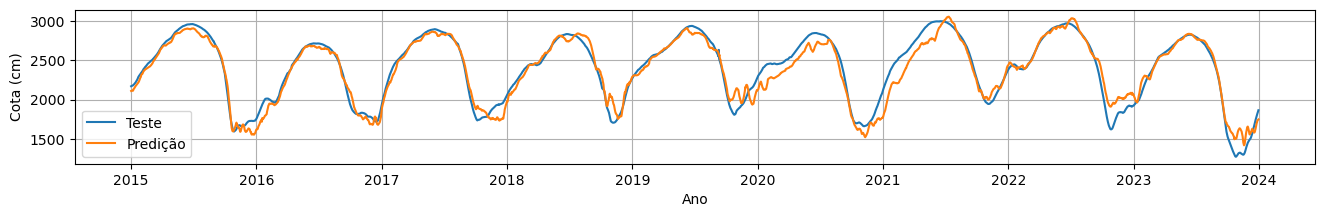

In [36]:
results(y_test, best_y_pred)

R²: 0.9077
MSE: 16354.8535
RMSE: 127.8861
MAE: 89.2432


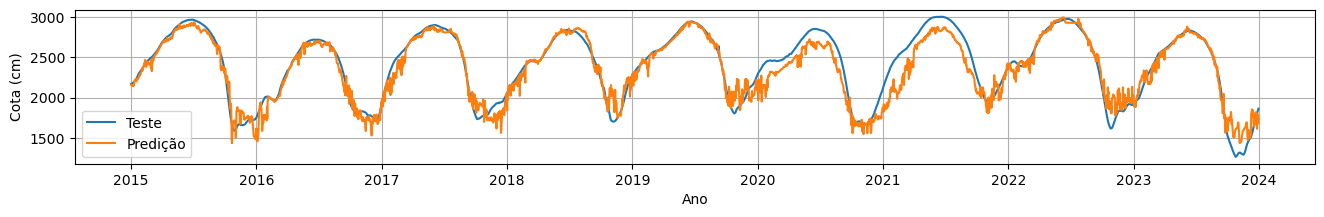

In [11]:
rf = RandomForestRegressor(
    n_jobs=-1, 
    n_estimators=500
)

rf.fit(x_train, y_train)
rf_y_pred = pd.DataFrame(rf.predict(x_test), index=y_test.index)

results(y_test, rf_y_pred)

R²: 0.8753
MSE: 22110.2341
RMSE: 148.6951
MAE: 108.5092


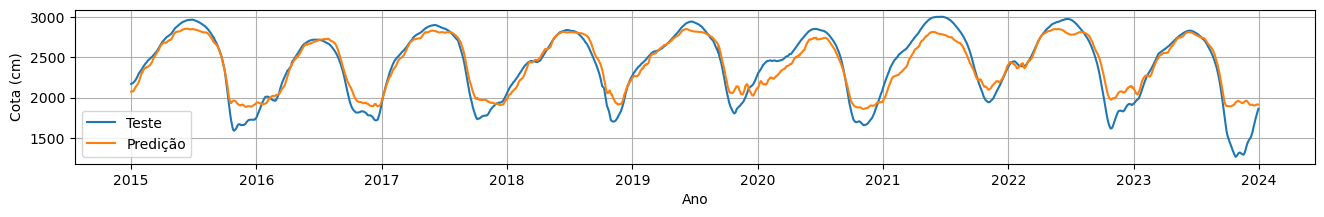

In [26]:
svr = SVR()

svr.fit(x_train, y_train)
svr_y_pred = pd.DataFrame(svr.predict(x_test), index=y_test.index)

results(y_test, svr_y_pred)